# `python-idb` demo

In [1]:
# !git clone https://github.com/williballenthin/python-idb
# !pip install ./python-idb

In [2]:
import idb

In [3]:
from collections import namedtuple
import networkx as nx

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Loading `write.i64`

In [5]:
with idb.from_file('../packer_example/write.i64') as db:
    api = idb.IDAPython(db)

section class not implemented: id2


#### Print the list of functions

In [6]:
for ea in api.idautils.Functions():
    print('%x: %s' % (ea, api.idc.GetFunctionName(ea)))

1000011c8: sub_1000011c8
100001238: sub_100001238
100001288: sub_100001288
1000014cc: sub_1000014cc
1000015a4: start
1000015d0: __security_check_cookie
1000015f8: TopLevelExceptionFilter
100001640: sub_100001640
10000165e: __C_specific_handler
10000166a: _XcptFilter
100001680: sub_100001680
1000016c0: sub_1000016c0
10000170c: sub_10000170c
100001754: _initterm
100001760: _amsg_exit
10000176c: sub_10000176c
100001778: sub_100001778
1000017d4: sub_1000017d4
100001820: sub_100001820
1000018dc: __report_gsfailure
100001a04: RtlVirtualUnwind
100001a10: RtlLookupFunctionEntry
100001a1c: sub_100001a1c
100001a3e: sub_100001a3e


#### Print the list of functions and the list of BBs

In [7]:
BasicBlock = namedtuple("BasicBlock", ["va", "size"])

def get_basic_blocks(fva, api):
    """
    return sequence of `BasicBlock` instances for given function.
    """
    ret = []
    func = api.ida_funcs.get_func(fva)
    if func is None:
        return ret

    for bb in api.idaapi.FlowChart(func):
        ret.append(BasicBlock(va=bb.startEA, size=bb.endEA - bb.startEA))

    return ret

In [8]:
with idb.from_file('../packer_example/write.i64') as db:
    api = idb.IDAPython(db)
    for ea in api.idautils.Functions():
        print('\n%x: %s' % (ea, api.idc.GetFunctionName(ea)))
        for bb in get_basic_blocks(ea, api):
            print("\t{} - size: {}".format(hex(bb.va), bb.size))

section class not implemented: id2



1000011c8: sub_1000011c8
	0x1000011c8 - size: 105

100001238: sub_100001238
	0x100001238 - size: 73

100001288: sub_100001288
	0x100001288 - size: 41
	0x1000012b1 - size: 16
	0x1000012c1 - size: 13
	0x1000012db - size: 13
	0x1000012ce - size: 5
	0x1000012e8 - size: 11
	0x1000012d3 - size: 8
	0x1000012f3 - size: 10
	0x1000012fd - size: 10
	0x100001364 - size: 11
	0x100001307 - size: 35
	0x10000135a - size: 10
	0x10000134c - size: 4
	0x10000136f - size: 29
	0x10000138c - size: 5
	0x10000132a - size: 5
	0x10000132f - size: 4
	0x100001350 - size: 10
	0x100001391 - size: 10
	0x10000139b - size: 9
	0x100001341 - size: 11
	0x100001333 - size: 8
	0x1000014ac - size: 26
	0x1000013a4 - size: 16
	0x1000013c3 - size: 12
	0x10000133b - size: 6
	0x1000014a0 - size: 12
	0x1000013cf - size: 10
	0x10000145c - size: 2
	0x100001498 - size: 8
	0x1000013b4 - size: 15
	0x1000013d9 - size: 12
	0x100001450 - size: 12
	0x100001448 - size: 8
	0x10000147f - size: 16
	0x1000013e5 - size: 6
	0x10000140a - size: 5

In [9]:
def get_function_graph(ea, api):
    '''
    Convert an IDA flowchart to a NetworkX DiGraph.
    It assumes all the BBs are withing the functions'
    limits.
    '''
    nx_graph = nx.DiGraph()
    basic_blocks = list()
    func = api.ida_funcs.get_func(ea)

    flowchart = api.idaapi.FlowChart(func)
    
    for block in flowchart:

        if block.endEA > func.endEA or block.startEA < func.startEA:
            continue

        nx_graph.add_node(block.startEA)

        for pred in block.preds():
            if pred.startEA >= func.startEA and pred.endEA <= func.endEA:
                nx_graph.add_edge(pred.startEA, block.startEA)

        for succ in block.succs():
            if succ.startEA >= func.startEA and succ.endEA <= func.endEA:
                nx_graph.add_edge(block.startEA, succ.startEA)

        basic_blocks.append((block.startEA, block.endEA))

    return nx_graph, basic_blocks

In [10]:
G, _ = get_function_graph(0x100001778, api)

In [11]:
# Nodes
[hex(x) for x in G.nodes()]

['0x100001778',
 '0x100001783',
 '0x1000017c5',
 '0x100001789',
 '0x1000017bd',
 '0x1000017bf',
 '0x100001793',
 '0x100001798',
 '0x1000017a1']

In [12]:
# Edges
[(hex(x[0]), hex(x[1])) for x in G.edges()]

[('0x100001778', '0x100001783'),
 ('0x100001778', '0x1000017c5'),
 ('0x100001783', '0x100001789'),
 ('0x100001783', '0x1000017c5'),
 ('0x100001789', '0x100001793'),
 ('0x100001789', '0x1000017bd'),
 ('0x1000017bd', '0x1000017c5'),
 ('0x1000017bf', '0x1000017c5'),
 ('0x100001793', '0x1000017bd'),
 ('0x100001793', '0x100001798'),
 ('0x100001798', '0x1000017bd'),
 ('0x100001798', '0x1000017a1'),
 ('0x1000017a1', '0x1000017bd')]

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:518: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


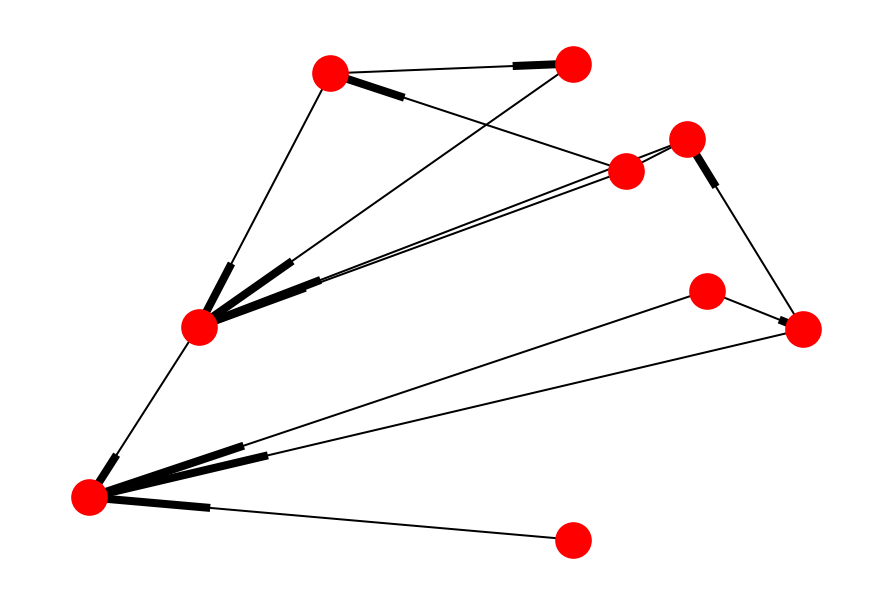

In [13]:
nx.draw(G)
plt.show()